 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.

# Outlook

In this notebook, you will code a naive actor-critic algorithm in the tabular case. Then you will tune it using grid search and Bayesian optimization, potentially using the [optuna](https://optuna.readthedocs.io/en/stable/) library.
Finally, you will get the best hyper-parameters obtained with both methods and perform a statistical test to see if there is a statistically significant difference between these methods and with respect to naive hyper-parameter values.

## Install libraries

In [123]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install 'easypip>=1.2.0'")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("swig")
easyinstall("bbrl>=0.2.2")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")
easyinstall("optuna")
easyinstall("gymnasium")
easyinstall("mazemdp")

import numpy as np
import os
from typing import List

import hydra
import optuna
import yaml
from omegaconf import OmegaConf, DictConfig

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video

In [124]:
import torch
import torch.nn as nn

In [125]:
import gymnasium as gym

from bbrl.utils.chrono import Chrono

import matplotlib
import matplotlib.pyplot as plt

from mazemdp.toolbox import sample_categorical
from mazemdp.mdp import Mdp
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
from functools import partial

# matplotlib.use("TkAgg")

# Step 1: Coding the naive Actor-critic algorithm

We consider the naive actor-critic algorithm with a categorical policy.
The algorithm learns a critic with the standard temporal difference mechanism
using a learning rate $\alpha_{critic}$.

We consider a value-based critic $V(s)$. The extension to an action value function $Q(s,a)$ is straightforward.

To update the critic, the algorithm computes the temporal difference error:

$$\delta_t = r(s_t, a_t) + \gamma V^{(n)}(s_{t+1})-V^{(n)}(s_t).$$

Then it applies it to the critic:

$$V^{(n+1)}(s_t) = V^{(n)}(s_t) + \alpha_{critic} \delta_t.$$

To update the actor, the general idea is the same, using the temporal difference error with another learning rate $\alpha_{actor}$.

However, naively applying the same learning rule would not ensure that the probabilities of all actions in a state sum to 1.
Besides, when the temporal difference error $\delta_t$ is negative, it may happen that the probability of an action gets negative or null, which raises an issue when applying renormalization.

So, instead of applying the naive rule, we apply the following one:
$$ 
\pi_{temp}(a_t|s_t) =  \begin{cases}
\pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t & \mathrm{if } \pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t > 10^{-8}\\
10^{-8} & \mathrm{otherwise.} \\
\end{cases}
$$

Then we can apply renormalization so that the probabilities of actions still sum to 1, with
$$
\forall a, \pi^{(i+1)}(a|s_t) = \frac{\pi_{temp}^{(i+1)}(a|s_t)} {\sum_{a'} \pi_{temp}^{(i+1)}(a'|s_t)}
$$ with
$$ 
\pi_{temp}^{(i+1)}(a|s_t) =  \begin{cases}
\pi_{temp}(a|s_t) & \mathrm{if } a = a_t\\
\pi^{(i)}(a|s_t) & \mathrm{otherwise.} \\
\end{cases}
$$

## Exercise 1

### 1. Code the naive actor-critic algorithm as specified above.

Some hints:

- a good idea to build this code it to take inspiration from the code of Q-learning, to add an actor (a categorical policy), both learning rates,
and to take care about the renormalization function.

- for the next steps of this lab, having a function to repeatedly call your actor-critic algorithm and save the learning trajectories and
norms of the value function is a good idea.

In [126]:
# Settings
NB_EPISODES = 100
TIMEOUT = 25
from mazemdp.toolbox import egreedy, egreedy_loc, sample_categorical, softmax


In [127]:
import gymnasium as gym

# Environment with 20% of walls and no negative reward when hitting a wall
env = gym.make(
    "MazeMDP-v0",
    kwargs={"width": 4, "height": 3, "ratio": 0.2, "hit": 0.0},
    render_mode="human",
)
env.reset()
env.unwrapped.init_draw("The maze")

       [ 1, -1,  6,  8],
       [ 2,  4, -1,  9]]), t…

In [128]:
def actor_critic(
    mdp: MazeMDPEnv,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha_critic: float = 0.5,
    alpha_actor: float = 0.5,
    render: bool = True,
    init_v: float = 0.0,
    uniform: bool = False):

    # Initialize the value function
    v = np.zeros(mdp.nb_states) 
    v_min = np.zeros(mdp.nb_states)
    v[:] = init_v
    v_list = []
    time_list = []
    pi = np.ones((mdp.nb_states, mdp.action_space.n))/mdp.action_space.n # The politic that we will update

    q = np.zeros((mdp.nb_states, mdp.action_space.n)) # Only used for display purposes

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Actor Critic")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=uniform)
        cpt = 0

        terminated = False
        truncated = False
        while not (terminated or truncated):
            # Show the agent in the maze
            if render:
                mdp.draw_v(q)

            # Draw an action
            u = sample_categorical(pi[x])

            # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(u)

            # Update the value function 
            delta = r + mdp.gamma*v[y]*(1-terminated) - v[x]
            v[x] = v[x] + alpha_critic*delta

            # Update the Policy
            pi[x,u] = max(pi[x,u] + delta*alpha_actor, 1e-8) 
            pi[x] = pi[x]/np.sum(pi[x])

            # Update the agent position
            x = y
            cpt = cpt + 1

        v_list.append(np.linalg.norm(np.maximum(v, v_min)))
        time_list.append(cpt)
    
    
    for s in range(len(q)): 
        a = np.argmax(pi[s])
        q[s,a] = v[s]
    
    if render:
        mdp.current_state = 0
        mdp.draw_v(q)
    

    return v, v_list, time_list


In [129]:
q, q_list, time_list = actor_critic(
    env, nb_episodes=25, timeout=TIMEOUT
)

       [ 1, -1,  6,  8],
       [ 2,  4, -1,  9]]), t…

### 2. Provide a plot function

Your plot function should show the evolution through time of number of steps the agent takes to find the reward in the maze.
If your algorithm works, this number of steps should decrease through time.

Your plot function should also show a mean and a standard deviation (or some more advanced statistics) over a collection of learning runs.

In [130]:
def plot_results(time_list_runs: list, nb_episodes: int):
    """
    This function plots the evolution of the number of steps the agent takes to reach the reward in the maze.
    It also shows the mean and standard deviation of these steps over multiple learning runs.

    Parameters:
    - time_list_runs: list of lists, where each list corresponds to the number of steps per episode for a single run.
    - nb_episodes: int, number of episodes per run.
    """
    # Convert list of lists to a numpy array for easier manipulation
    time_list_runs = np.array(time_list_runs)  # Shape: (nb_runs, nb_episodes)

    # Calculate the mean and standard deviation across all runs for each episode
    mean_steps = np.mean(time_list_runs, axis=0)
    std_steps = np.std(time_list_runs, axis=0)

    # Create an array of episodes for plotting
    episodes = np.arange(nb_episodes)

    # Plot the mean steps per episode
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, mean_steps, label='Mean steps per episode', color='blue')

    # Plot the standard deviation around the mean
    plt.fill_between(episodes, mean_steps - std_steps, mean_steps + std_steps, color='blue', alpha=0.3, label='Standard deviation')

    # Add labels and title
    plt.xlabel('Episode')
    plt.ylabel('Number of steps')
    plt.title('Steps to find the reward over time')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()



## Actor-critic hyper-parameters

To represent the hyper-parameters of the experiments performed in this notebook, we suggest using the dictionary below.
This dictionary can be read using omegaconf.
Using it is not mandatory.
You can also change the value of hyper-parameters or environment parameters at will.

In [131]:
ac_params = {
    "save_curves": False,
    "save_heatmap": True,
    "mdp": {
        "name": "MazeMDP-v0",
        "width": 5,
        "height": 5,
        "ratio": 0.2,
        "render_mode": "rgb_array",
        },
        
    "log_dir": "./tmp",
    "video_dir": "./tmp/videos",

    "nb_episodes": 100,
    "timeout": 200,
    "render": False, # True, # 
    "nb_repeats": 5,

    "alpha_critic": 0.5,
    "alpha_actor": 0.5,
    }

### 3. Test your code

Once everything looks OK, save the obtained plot for your lab report

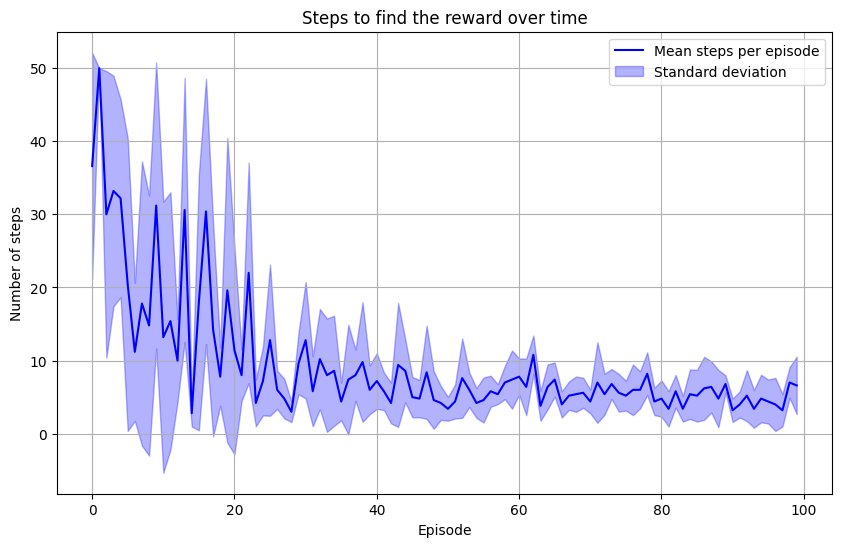

In [132]:
# Effectuer plusieurs runs de l'algorithme actor-critic
nb_runs = 5
time_list_runs = []

for _ in range(nb_runs):
    _, _, time_list = actor_critic(env, nb_episodes=NB_EPISODES, timeout=TIMEOUT, alpha_critic=0.5, alpha_actor=0.5, render=False)
    time_list_runs.append(time_list)

# Tracer les résultats
plot_results(time_list_runs, NB_EPISODES)


# Step 2: Tuning hyper-parameters

In this part, you have to optimize two hyper-parameters of the actor-critic algorithm, namely the actor and critic learning rates.
You have to do so using a simple grid search method and some Bayesian optimization method.
For the latter, we suggest using the default sampler from [optuna](https://optuna.readthedocs.io/en/stable/).
Follow the above link to understand how optuna works.
Note that it also supports grid search and many other hyper-parameters tuning algorithms.

You should make sure that the hyper-parameters tuning algorithms that you compare benefit from the same training budget
We suggest 400 training runs overall for each method,
which means 20 values each for the actor and the critic learning rates in the case of grid search.

## Exercise 2

### 1. Perform hyper-parameters tuning with two algorithms as suggested above.

### 2. Provide a "heatmap" of the norm of the value function given the hyper-parameters, after training for each pair of hyper-parameters.

### 3. Collect the value of the best hyper-parameters found with each algorithm. You will need them for Step 3.

### 4. Include in your report the heatmaps and the best hyper-parameters found for each method.

In [133]:
NB_env = 5  # Nombre d'environnements différents à utiliser
env_list = []
for i in range(NB_env):
    env_list.append(gym.make("MazeMDP-v0", 
                            kwargs={"width": 4, "height": 3, "ratio": 0.2, "hit": 0.0},
                            render_mode="human")
                    )

In [134]:
def plot_heatmap(results, actor_lr_values, critic_lr_values, best_params=None):
    heatmap_data = np.zeros((len(actor_lr_values), len(critic_lr_values)))

    # Remplir la heatmap avec les normes de la fonction de valeur
    for (actor_lr, critic_lr, norm_value) in results:
        i = np.where(np.isclose(actor_lr_values, actor_lr))[0][0]
        j = np.where(np.isclose(critic_lr_values, critic_lr))[0][0]
        heatmap_data[i, j] = norm_value

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(heatmap_data, xticklabels=critic_lr_values, yticklabels=actor_lr_values, annot=True, cmap="viridis")

    plt.title("Heatmap du nombre de pas pour chaque paire (alpha_actor, alpha_critic)")
    plt.xlabel("Critic Learning Rate")
    plt.ylabel("Actor Learning Rate")

    # Si les meilleurs hyperparamètres sont donnés, ajouter un marqueur
    if best_params:
        best_actor_lr, best_critic_lr = best_params
        i = np.where(np.isclose(actor_lr_values, best_actor_lr))[0][0]
        j = np.where(np.isclose(critic_lr_values, best_critic_lr))[0][0]

        # Ajouter un cercle rouge pour indiquer les meilleurs hyperparamètres
        ax.scatter(j + 0.5, i + 0.5, color="red", s=200, label="Best Params", marker="o", edgecolor="black", linewidth=2)

        # Ajouter une légende
        plt.legend(loc="upper right")

    plt.show()

In [135]:
from copy import deepcopy
import seaborn as sns

def grid_search_actor_critic(ac_params):
    # Définir les plages de valeurs pour les taux d'apprentissage de l'acteur et du critique
    actor_lr_values = np.linspace(0.01, 1.0, 20)  # 20 valeurs entre 0.01 et 1.0
    critic_lr_values = np.linspace(0.01, 1.0, 20)  # 20 valeurs entre 0.01 et 1.0

    best_score = float('inf')
    best_params = None
    results = []

    # Parcourir toutes les combinaisons de taux d'apprentissage
    for actor_lr in actor_lr_values:
        for critic_lr in critic_lr_values:
            time_list_all_envs = []
            norm_value_all_envs = []
            
            # Répéter l'expérience sur plusieurs environnements
            for env in env_list:

                # Créer une copie du dictionnaire pour éviter les modifications globales
                ac_params_run = deepcopy(ac_params)
                ac_params_run["alpha_actor"] = actor_lr
                ac_params_run["alpha_critic"] = critic_lr

                time_list_runs = []
                norm_values = []

                # Effectuer plusieurs répétitions pour chaque combinaison dans cet environnement
                for _ in range(ac_params_run["nb_repeats"]):  
                    v, _, time_list = actor_critic(
                        mdp=env, 
                        nb_episodes=ac_params_run["nb_episodes"], 
                        timeout=ac_params_run["timeout"], 
                        alpha_critic=critic_lr, 
                        alpha_actor=actor_lr, 
                        render=ac_params_run["render"])

                    # Calcul de la norme de la fonction de valeur
                    norm_value = np.linalg.norm(v)
                    norm_values.append(norm_value)

                    time_list_runs.append(time_list)

                # Ajouter les performances de cet environnement à la liste globale
                avg_norm_for_env = np.mean(norm_values)
                avg_time_for_env = np.mean([np.mean(time) for time in time_list_runs])

                time_list_all_envs.append(avg_time_for_env)
                norm_value_all_envs.append(avg_norm_for_env)

            # Calculer la performance moyenne sur tous les environnements
            avg_score_all_envs = np.mean(time_list_all_envs)
            avg_norm_value_all_envs = np.mean(norm_value_all_envs)

            # Enregistrer les résultats (hyperparamètres, norme de la fonction de valeur)
            results.append((actor_lr, critic_lr, avg_score_all_envs))

            # Mettre à jour les meilleurs hyperparamètres
            if avg_score_all_envs < best_score:
                best_score = avg_score_all_envs
                best_params = (actor_lr, critic_lr)
    
    # Générer la heatmap à la fin de l'exploration

    print(f"Meilleurs paramètres: Actor LR = {best_params[0]}, Critic LR = {best_params[1]}")
    return best_params, results

# Utilisation avec le dictionnaire de paramètres
best_params_grid, grid_results = grid_search_actor_critic(ac_params)


Meilleurs paramètres: Actor LR = 1.0, Critic LR = 0.7394736842105263


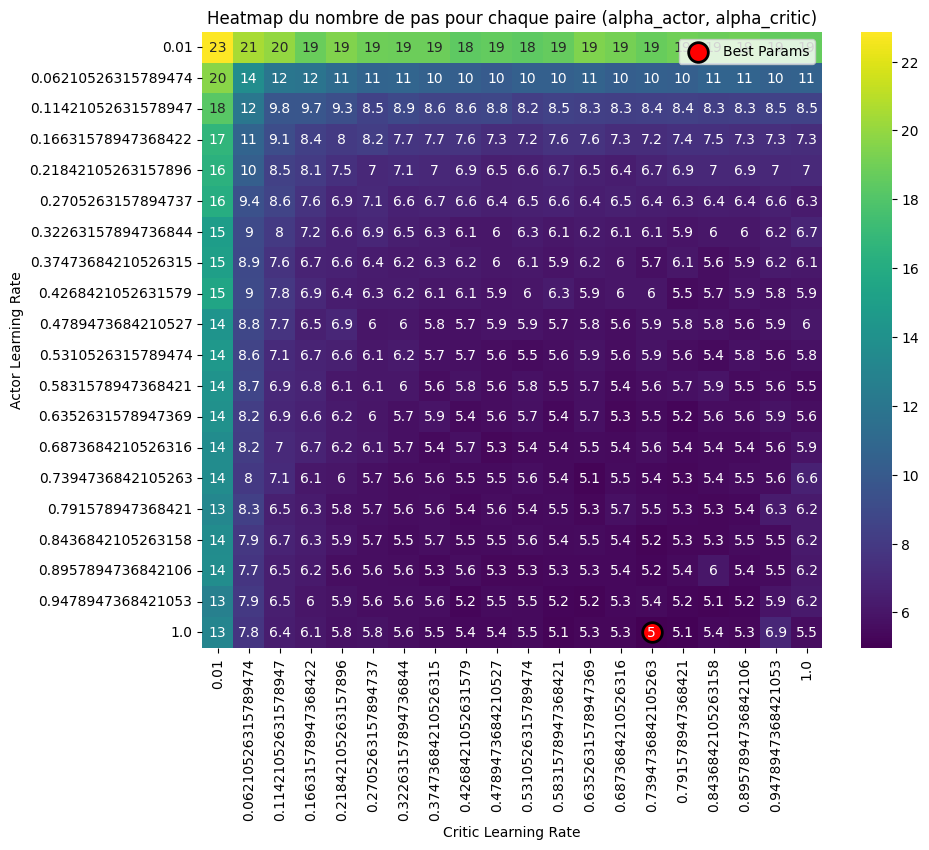

In [136]:
plot_heatmap(grid_results, np.linspace(0.01, 1.0, 20), np.linspace(0.01, 1.0, 20), best_params_grid)

In [137]:
import optuna
import optuna.visualization as vis

def objective(trial, ac_params):
    actor_lr = trial.suggest_float("alpha_actor", 0.01, 1.0, log=True)
    critic_lr = trial.suggest_float("alpha_critic", 0.01, 1.0, log=True)

    time_list_all_envs = []
    norm_value_all_envs = []

    # Répéter l'expérience sur plusieurs environnements
    for env in env_list:

        # Créer une copie du dictionnaire pour éviter les modifications globales
        ac_params_run = deepcopy(ac_params)
        ac_params_run["alpha_actor"] = actor_lr
        ac_params_run["alpha_critic"] = critic_lr

        time_list_runs = []
        norm_values = []

        for _ in range(ac_params_run["nb_repeats"]):  
            v, _, time_list = actor_critic(
                mdp=env, 
                nb_episodes=ac_params_run["nb_episodes"], 
                timeout=ac_params_run["timeout"], 
                alpha_critic=critic_lr, 
                alpha_actor=actor_lr, 
                render=ac_params_run["render"])

            norm_value = np.linalg.norm(v)
            norm_values.append(norm_value)

            time_list_runs.append(time_list)

        avg_norm_for_env = np.mean(norm_values)
        avg_time_for_env = np.mean([np.mean(time) for time in time_list_runs])

        time_list_all_envs.append(avg_time_for_env)
        norm_value_all_envs.append(avg_norm_for_env)

    avg_score_all_envs = np.mean(time_list_all_envs)
    avg_norm_value_all_envs = np.mean(norm_value_all_envs)

    trial.set_user_attr("norm_value", avg_norm_value_all_envs)
    
    return avg_score_all_envs

def optimize_with_optuna(ac_params, n_trials=400):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, ac_params), n_trials=n_trials)

    best_params = study.best_params
    best_value = study.best_value

    # Collecte des normes de la fonction de valeur pour toutes les études
    norm_values = [trial.user_attrs["norm_value"] for trial in study.trials]

    # Générer la heatmap à partir des résultats d'Optuna
    actor_lr_values = [trial.params["alpha_actor"] for trial in study.trials]
    critic_lr_values = [trial.params["alpha_critic"] for trial in study.trials]
    results = list(zip(actor_lr_values, critic_lr_values, norm_values))
    
    # Affichage des meilleurs paramètres
    
    print(f"Meilleurs paramètres: {best_params}")
    print(f"Score obtenu avec les meilleurs paramètres: {best_value}")

    # Visualisation des résultats avec Optuna
    # Contour plot (heatmap avec interpolation) pour les paramètres alpha_actor et alpha_critic
    vis.plot_contour(study, params=["alpha_actor", "alpha_critic"]).show()

    # Vous pouvez également afficher d'autres visualisations :
    # Graphique de l'évolution de l'optimisation
    vis.plot_optimization_history(study).show()

    # Importance des hyperparamètres
    vis.plot_param_importances(study).show()

    return best_params, results

# Utilisation avec le dictionnaire de paramètres
best_params_optuna, results_optuna = optimize_with_optuna(ac_params)


[I 2024-09-29 17:00:05,560] A new study created in memory with name: no-name-6a9a9d8f-e68f-4db5-ae0d-ac2befc679f4
/home/hatem/deepdac/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning:

WARN: env.nb_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nb_states` for environment variables or `env.get_wrapper_attr('nb_states')` that will search the reminding wrappers.

/home/hatem/deepdac/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning:

WARN: env.gamma to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.gamma` for environment variables or `env.get_wrapper_attr('gamma')` that will search the reminding wrappers.

[I 2024-09-29 17:00:06,836] Trial 0 finished with value: 11.7216 and parameters: {'alpha_actor': 0.18335359575539037, 'alpha_critic': 0.03967023563899481}. Best is trial 0 with value: 11.7216.
[I 

Meilleurs paramètres: {'alpha_actor': 0.9044080104630862, 'alpha_critic': 0.8299661695037767}
Score obtenu avec les meilleurs paramètres: 4.9676


# Step 3: Statistical tests

Now you have to compare the performance of the actor-critic algorithm tuned
with all the best hyper-parameters you found before, using statistical tests.

The functions below are provided to run Welch's T-test over learning curves.
They have been adapted from a github repository: https://github.com/flowersteam/rl_stats
You don't need to understand them in detail (though it is always a good idea to try to understand more code).

In [138]:
from scipy.stats import ttest_ind
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

In [139]:
def compute_central_tendency_and_error(id_central, id_error, sample):

    try:
        id_error = int(id_error)
    except:
        pass

    if id_central == "mean":
        central = np.nanmean(sample, axis=1)
    elif id_central == "median":
        central = np.nanmedian(sample, axis=1)
    else:
        raise NotImplementedError

    if isinstance(id_error, int):
        low = np.nanpercentile(sample, q=int((100 - id_error) / 2), axis=1)
        high = np.nanpercentile(sample, q=int(100 - (100 - id_error) / 2), axis=1)
    elif id_error == "std":
        low = central - np.nanstd(sample, axis=1)
        high = central + np.nanstd(sample, axis=1)
    elif id_error == "sem":
        low = central - np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
        high = central + np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
    else:
        raise NotImplementedError

    return central, low, high

In [140]:
def run_test(test_id, data1, data2, alpha=0.05):
    """
    Compute tests comparing data1 and data2 with confidence level alpha
    :param test_id: (str) refers to what test should be used
    :param data1: (np.ndarray) sample 1
    :param data2: (np.ndarray) sample 2
    :param alpha: (float) confidence level of the test
    :return: (bool) if True, the null hypothesis is rejected
    """
    data1 = data1.squeeze()
    data2 = data2.squeeze()
    n1 = data1.size
    n2 = data2.size

    # perform Welch t-test":
    _, p = ttest_ind(data1, data2, equal_var=False)
    return p < alpha

This last function was adapted for the lab.

In [141]:
def perform_test(perf1, perf2, name1, name2, sample_size=20, downsampling_fact=5, confidence_level=0.01):

    perf1 = perf1.transpose()
    perf2 = perf2.transpose()
    nb_datapoints = perf1.shape[1]
    nb_steps = perf1.shape[0]

    legend = [name1, name2]

    # what do you want to plot ?
    id_central = 'mean' # "median"  # 
    id_error = 80  # (percentiles), also: 'std', 'sem'

    test_id = "Welch t-test"  # recommended
    
    sample1 = perf1[:, np.random.randint(0, nb_datapoints, sample_size)]
    sample2 = perf2[:, np.random.randint(0, nb_datapoints, sample_size)]

    steps = np.arange(0, nb_steps, downsampling_fact)
    sample1 = sample1[steps, :]
    sample2 = sample2[steps, :]

    # test
    sign_diff = np.zeros([len(steps)])
    for i in range(len(steps)):
        sign_diff[i] = run_test(
            test_id, sample1[i, :], sample2[i, :], alpha=confidence_level
        )

    central1, low1, high1 = compute_central_tendency_and_error(
        id_central, id_error, sample1
    )
    central2, low2, high2 = compute_central_tendency_and_error(
        id_central, id_error, sample2
    )

    # plot
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    lab1 = plt.xlabel("training steps")
    lab2 = plt.ylabel("performance")

    plt.plot(steps, central1, linewidth=10)
    plt.plot(steps, central2, linewidth=10)
    plt.fill_between(steps, low1, high1, alpha=0.3)
    plt.fill_between(steps, low2, high2, alpha=0.3)
    leg = ax.legend(legend, frameon=False)

    # plot significative difference as dots
    idx = np.argwhere(sign_diff == 1)
    y = max(np.nanmax(high1), np.nanmax(high2))
    plt.scatter(steps[idx], y * 1.05 * np.ones([idx.size]), s=100, c="k", marker="o")

    # style
    for line in leg.get_lines():
        line.set_linewidth(10.0)
    ax.spines["top"].set_linewidth(5)
    ax.spines["right"].set_linewidth(5)
    ax.spines["bottom"].set_linewidth(5)
    ax.spines["left"].set_linewidth(5)

    plt.savefig(
        f"./{name1}_{name2}.png", bbox_extra_artists=(leg, lab1, lab2), bbox_inches="tight", dpi=100
    )
    # plt.show()

## Exercise 3

As hyper-parameters, you will use:

- naive tuning, that is a pair (0.5, 0.5) for the actor and critic learning rates,
- the best hyper-parameters you found with the different tuning algorithms you used before.

### 1. For each set of hyper-parameters, collect a large dataset of learning curves.

We suggest using 150 training episodes.

### 2. Perform statistical comparisons

- Take two datasets of learning curves obtained with the hyper-parameters sets that you found with different tuning algorithms.
- Use the ``` perform_test(...)``` function to compare each possible pair of sets.

You should obtain an image for each pair you have tried.
In this image, black dots signal the time step where there is a statistically significant difference between two learning curves.

 ### 3. Conclude.

In [142]:
import numpy as np
from copy import deepcopy

# Générer les courbes d'apprentissage
def collect_learning_curves(ac_params, alpha_critic, alpha_actor, nb_env=5, nb_repeats=5, nb_episodes=150):
    """
    Collecte les courbes d'apprentissage pour une combinaison donnée d'hyperparamètres.
    Retourne une matrice (150 épisodes, 5 répétitions).
    """
    learning_curves = []

    # Créer une copie des paramètres pour cet environnement
    ac_params_run = deepcopy(ac_params)
    ac_params_run["alpha_critic"] = alpha_critic
    ac_params_run["alpha_actor"] = alpha_actor
    ac_params_run["nb_episodes"] = nb_episodes
    ac_params_run["nb_repeats"] = nb_repeats

    # Itérer sur plusieurs environnements
    for env in env_list:

        # Charger un nouvel environnement
        # env = gym.make("MazeMDP-v0", kwargs={"width": 4, "height": 3, "ratio": 0.2, "hit": 0.0}, render_mode="human")

        # Stocker les résultats pour cet environnement
        time_list_runs = []

        # Faire nb_repeats répétitions pour cet environnement
        for _ in range(ac_params_run["nb_repeats"]):
            _, v_list, time_list = actor_critic(
                mdp=env,
                nb_episodes=ac_params_run["nb_episodes"],
                timeout=ac_params_run["timeout"],
                alpha_critic=alpha_critic,
                alpha_actor=alpha_actor,
                render=ac_params_run["render"]
            )
            time_list_runs.append(time_list)  # Ajouter les performances

        # Ajouter à la matrice globale pour cet environnement
        learning_curves.append(np.array(time_list_runs).T)  # Transposer pour avoir (nb_episodes, nb_repeats)

    # Moyenne sur les 5 environnements
    learning_curves = np.mean(np.array(learning_curves), axis=0)  # Moyenne sur 5 environnements

    return learning_curves

# Configuration naïve (0.5, 0.5)
learning_curves_naive = collect_learning_curves(ac_params, alpha_critic=0.5, alpha_actor=0.5)

# Configuration optimisée par Grid Search
best_alpha_actor, best_alpha_critic = best_params_grid
learning_curves_grid = collect_learning_curves(ac_params, alpha_critic=best_alpha_critic, alpha_actor=best_alpha_actor)

learning_curves_bayesian = collect_learning_curves(ac_params, alpha_critic=best_params_optuna["alpha_critic"], alpha_actor=best_params_optuna["alpha_actor"])

# À ce stade, nous avons deux matrices :
# - learning_curves_naive : (150 épisodes, 5 répétitions)
# - learning_curves_grid : (150 épisodes, 5 répétitions)


/home/hatem/deepdac/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning:

WARN: env.nb_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nb_states` for environment variables or `env.get_wrapper_attr('nb_states')` that will search the reminding wrappers.

/home/hatem/deepdac/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning:

WARN: env.gamma to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.gamma` for environment variables or `env.get_wrapper_attr('gamma')` that will search the reminding wrappers.



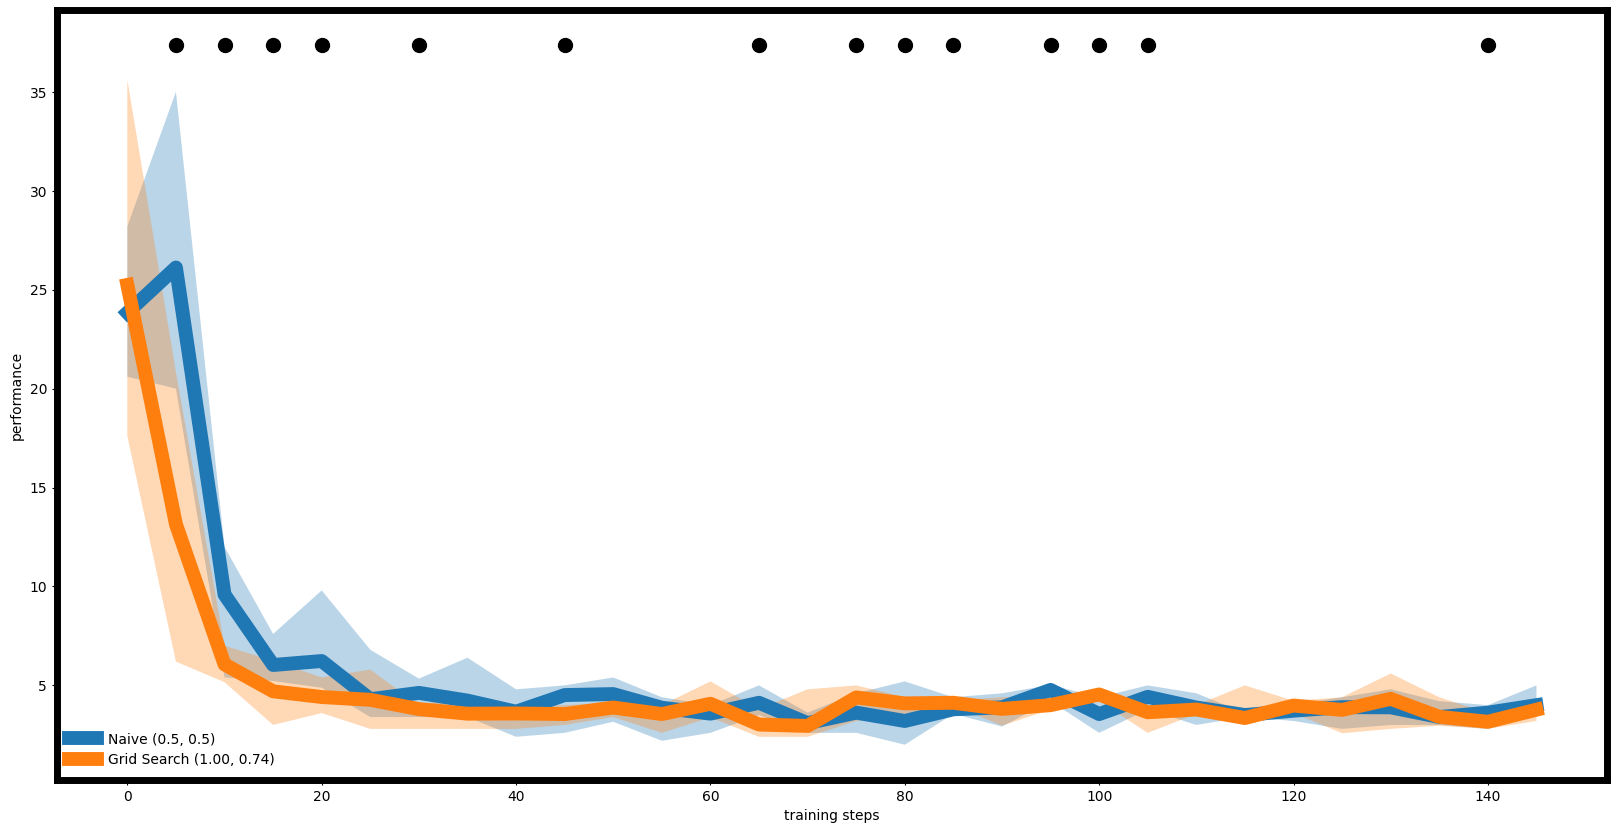

In [144]:
# Comparer les performances entre la configuration naïve et la configuration Grid Search
perform_test(
    perf1=learning_curves_naive.T,
    perf2=learning_curves_bayesian.T,
    name1="Naive (0.5, 0.5)",
    name2=f"Grid Search ({best_alpha_actor:.2f}, {best_alpha_critic:.2f})",
    sample_size=20,  # Taille d'échantillon pour chaque test statistique
    downsampling_fact=5,  # Réduire les points pour accélérer l'analyse
    confidence_level=0.01  # Niveau de confiance pour le Welch's t-test
)


# Lab report

Your report should contain:
- your source code (probably this notebook), do not forget to put your names on top of the notebook,
- in a separate pdf file with your names in the name of the file:
    + a detailed enough description of the choices you have made: the parameters you have set, the libraries you have used, etc.,
    + the heatmaps obtained using the hyper-parameters tuning algorithms that you have used,
    + the figures resulting from performing Welch's T-test using the best hyper-parameters from the above approaches,
    + your conclusion from these experiments.

Beyond the elements required in this report, any additional studies will be rewarded.
For instance, you can try using a Q-function as critic, using random search as hyper-parameters tuning algorithm,
using more challenging environments, etc.